In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import ElasticNetCV
from linearmodels.panel import PanelOLS, FamaMacBeth

os.chdir('/Users/yiyujie/Desktop/program/ML')

## Question 1: Valuation with Machine Learning, version 1
We will predict current log equity market value, **lnME**. Next, we will construct the features we will use to do so. First, create log book value by setting **lnBE = lnBM + lnME**. That is, add the log market value to the log book-to-market ratio. Next, in addition to **lnBE**, we will also consider the characteristics **lnIssue, lnProf, lnInv, lnLever, lnMOM, lnROE, and rv**. Thus, you have eight characteristics in total. For each of these seven characteristics, create new, additional characteristics as the squared value of the original characteristic. Name the new characteristics the same as the original, but with a "2" at the end. For instance, for **lnProf**, the squared value should be **lnProf2**. Also, create interaction terms where you multiply each of these characteristics with **lnBE** (except lnBE itself, as this would simply give lnBE^2, which you already have). Finally, create 11 dummy variables using the ff_ind industry variable. There are twelve possible industries, but skip the 12th one when creating dummies as the regressions we will run have intercepts. You should now have 8+8+7+11 features that you will use to predict **lnME**.
* For each year in the sample, run a cross-sectional regression of **lnME** on these features. Get the predicted values **lnME_hat** from this regression each year. Plot the R2 from these regressions across the years in the sample. That is, R2 on the y axis and year on the x axis. Comment on any interesting patterns you see in terms of this model’s ability to explain equity market values across firms.

In [2]:
StockRetAcct = pd.read_csv('StockRetAcct_DT.csv',header = 0, sep = ',').drop('Unnamed: 0', axis=1)
# construct 8+8+7+11 features
StockRetAcct['lnBE'] = StockRetAcct['lnBM'] + StockRetAcct['lnME']
X = pd.get_dummies(StockRetAcct['ff_ind']).drop([12.0], axis = 1)
X.columns = ['ff_ind'+str(int(i)) for i in list(X.columns)]
StockRetAcct = pd.concat([StockRetAcct,X],axis=1)
X_columns = list(X.columns)
for column in ['lnBE', 'lnIssue', 'lnProf', 'lnInv', 'lnLever', 'lnMom', 'lnROE','rv']:
    StockRetAcct[column+'2'] = StockRetAcct[column]**2
    X_columns.append(column)
    X_columns.append(column+'2')
    if column != 'lnBE':
        StockRetAcct[column+'_lnBE'] = StockRetAcct[column] *  StockRetAcct['lnBE']
        X_columns.append(column+'_lnBE')

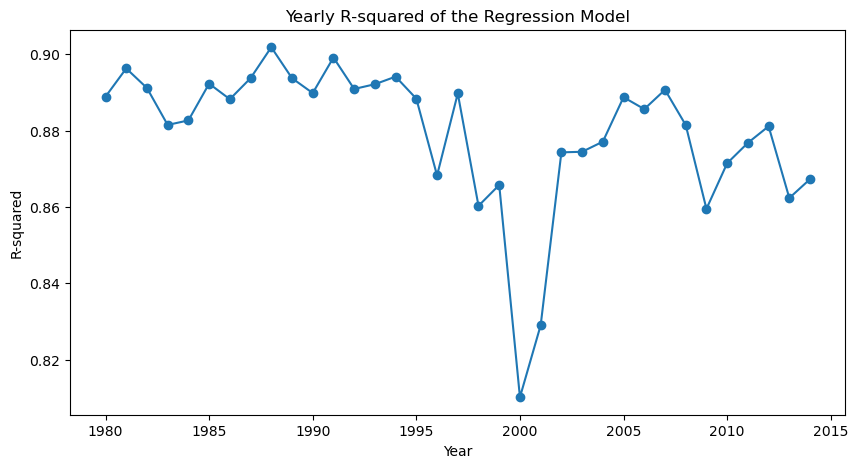

In [3]:
s = ''
for i in X_columns:
    s += '+ ' + i

results = []
StockRetAcct['lnME_hat'] = np.nan
# Run regression for each year
for year in StockRetAcct['year'].unique():
    StockRetAcct_year = StockRetAcct[StockRetAcct['year'] == year].dropna(subset = X_columns)
    model = smf.ols('lnME ~ 1' + s, data = StockRetAcct_year).fit()
    StockRetAcct.loc[StockRetAcct_year.index, 'lnME_hat'] = model.predict()
    results.append((year,model.rsquared))
results = pd.DataFrame(results,columns=['year','r_square']).sort_values(by='year')

# Plotting R-squared over years
plt.figure(figsize=(10, 5))
plt.plot(results['year'], results['r_square'], marker='o')
plt.title('Yearly R-squared of the Regression Model')
plt.xlabel('Year')
plt.ylabel('R-squared')
plt.show()

* Create the variable **z_OLS = lnME – lnME_hat**. That is, for each firm each year create a measure of mispricing as the actual market value minus the predicted market value.

In [4]:
StockRetAcct['z_OLS'] = StockRetAcct['lnME'] - StockRetAcct['lnME_hat']

* Next, you are to use the **Elastic Net** procedure (with alpha (l1_ratio) =0.5) to estimate **lnME_hat**. Each year, run a cross-validation exercise with 10 folds. Find the optimal regularization parameter, and then run the Elastic Net procedure using all the firms for that year. The sklearn procedure ElasticNet could be useful here, as well as ElasticNetCV. Plot the chosen regularization parameter for each year.

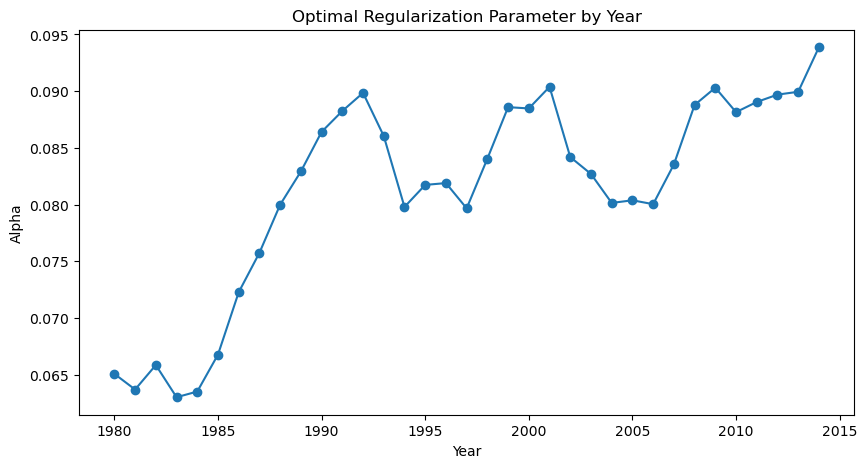

In [5]:
StockRetAcct['lnME_hat_EN'] = np.nan

results = []
# Perform Elastic Net CV for each year
for year in StockRetAcct['year'].unique():
    StockRetAcct_year = StockRetAcct[StockRetAcct['year'] == year].dropna(subset = X_columns)
    X = sm.add_constant(StockRetAcct_year[X_columns])
    Y = StockRetAcct_year['lnME']

    # Elastic Net Model with alpha=0.5
    model_en_cv = ElasticNetCV(l1_ratio=0.5, cv=10)
    model_en_cv.fit(X, Y)
    StockRetAcct.loc[StockRetAcct_year.index, 'lnME_hat_EN'] = model_en_cv.predict(X)
    
    # Store optimal lambda (alpha) for the year
    results.append((year,model_en_cv.alpha_))

results = pd.DataFrame(results,columns=['year','alpha']).sort_values(by='year')

# Plotting R-squared over years
plt.figure(figsize=(10, 5))
plt.plot(results['year'], results['alpha'], marker='o')
plt.title('Optimal Regularization Parameter by Year')
plt.xlabel('Year')
plt.ylabel('Alpha')
plt.show()

* Collect the predicted market values for the Elastic Net procedure, **lnME_hat_EN**. Then
create the mispricing variable **z_EN = lnME – lnME_hat_EN** for each firm and year.

In [6]:
StockRetAcct['z_EN'] = StockRetAcct['lnME'] - StockRetAcct['lnME_hat_EN']

* Create firm excess returns as **ExRet = lnAnnRet – lnRf**. Given how I constructed the data, this is next year’s return. Each year, run a cross-sectional regression of ExRet on an intercept and the mispricing variables z_OLS and z_EN (that is, run the Fama-MacBeth regression to get the portfolio returns based on sorts on these variables).
Report the slope in the Fama-MacBeth regression (the average excess portfolio return for each of z_OLS and z_EN), as well of their t-statistics ((average excess return / stdev of returns) * sqrt(T)). Are any of these signals, z_OLS or z_EN, useful for predicting returns? Which one seems best?

In [11]:
StockRetAcct.set_index(['ff_ind', 'year'], inplace=True)
StockRetAcct['ExRet'] = StockRetAcct['lnAnnRet'] - StockRetAcct['lnRf']
StockRetAcct['const'] = 1

In [14]:
model = FamaMacBeth(dependent = StockRetAcct['ExRet'], exog = StockRetAcct[['const', 'z_OLS']])
results = model.fit()
print('The results for z_OLS: ')
print('Mean: ', results.predict().mean().iloc[0], 'Std: ', results.predict().std().iloc[0], 
      'Sharpe Ratio: ', results.predict().mean().iloc[0]/results.predict().std().iloc[0], 'tstats: ', results.tstats['z_OLS'],
     'p_values: ', results.pvalues['z_OLS'])

The results for z_OLS: 
Mean:  0.0051960427858014895 Std:  0.006606825512327549 Sharpe Ratio:  0.786465871711958 tstats:  -1.1337136490317414 p_values:  0.25691933818254453


In [15]:
model = FamaMacBeth(dependent = StockRetAcct['ExRet'], exog = StockRetAcct[['const', 'z_EN']])
results = model.fit()
print('The results for z_EN: ')
print('Mean: ', results.predict().mean().iloc[0], 'Std: ', results.predict().std().iloc[0], 
      'Sharpe Ratio: ', results.predict().mean().iloc[0]/results.predict().std().iloc[0], 'tstats: ', results.tstats['z_EN'],
     'p_values: ', results.pvalues['z_EN'])

The results for z_EN: 
Mean:  0.0051960427858019536 Std:  0.013307033818560755 Sharpe Ratio:  0.39047340351344656 tstats:  -1.6814829640194078 p_values:  0.0926744918505431


* t-statistics: The t-statistic is a measure of how many standard deviations the estimated coefficient is away from zero. In your results, both t-statistics are negative, and their magnitudes don't indicate strong statistical significance (absolute value less than 2).
* p-value: The p-value for z_OLS is above conventional significance levels (like 0.05 or 0.1), indicating that z_OLS is not statistically significant in predicting returns. On the other hand, the p-value for z_EN is closer to the 0.1 level, suggesting some level of significance, albeit weak.

* Choosing either z_OLS or z_EN based on which gives the highest portfolio Sharpe ratio, now run the Fama-MacBeth regressions including lnBM, lnProf, lnInv, lnMom, as well as industry dummies on the right hand side. Is the mispricing signal z that you chose marginally useful now?

In [16]:
exog = StockRetAcct[['const', 'z_OLS', 'lnBM', 'lnProf', 'lnInv', 'lnMom'] + X_columns[:11]]
endog = StockRetAcct['ExRet']

results = FamaMacBeth(dependent=endog, exog=exog).fit()

# Display the results
print(results.summary)

                             FamaMacBeth Estimation Summary                            
Dep. Variable:                         ExRet   R-squared:                        0.0396
Estimator:                       FamaMacBeth   R-squared (Between):              0.9285
No. Observations:                      58378   R-squared (Within):               0.0346
Date:                       Sat, Apr 27 2024   R-squared (Overall):              0.0396
Time:                               21:26:45   Log-likelihood                 -3.57e+04
Cov. Estimator:    Fama-MacBeth Standard Cov                                           
                                               F-statistic:                      150.49
Entities:                                 12   P-value                           0.0000
Avg Obs:                              4864.8   Distribution:                F(16,58361)
Min Obs:                              1587.0                                           
Max Obs:                        

* z_OLS has a higher Sharpe Ratio compared to z_EN, which implies that per unit of risk, z_OLS provides a higher excess return than z_EN. Normally, a higher Sharpe Ratio is preferred because it indicates better risk-adjusted performance.
* The coefficient for z_OLS is 0.0469 with a t-statistic of 3.4801 and a p-value of 0.0005, which indicates that it is statistically significant even at the 1% level.
* The positive coefficient suggests that a higher z_OLS value is associated with higher excess returns. Given that it remains significant even after including other variables like lnBM, lnProf, lnInv, lnMom, and industry dummies, we can infer that z_OLS provides information about expected returns that is not captured by these other factors.